<a href="https://colab.research.google.com/github/sharonston25/stock_market-/blob/main/streamlit_app_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance joblib --quiet



In [2]:
# ===== Cell 2: imports & params =====
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import datetime as dt

plt.rcParams['figure.figsize'] = (12,6)

# Parameters you can tweak
TICKER = "AAPL"          # change to any ticker (e.g., "GOOG","TSLA")
START = "2015-01-01"
END = dt.datetime.today().strftime("%Y-%m-%d")
SEQ_LEN = 60             # days of history used to predict next day
EPOCHS = 20              # reduce for quick demo, raise for more accuracy
BATCH = 32


In [3]:
# ===== Cell 3: download data =====
df = yf.download(TICKER, start=START, end=END, progress=False)
if df.empty:
    raise SystemExit(f"No data for ticker {TICKER}")
df.tail()


/tmp/ipython-input-138212412.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-08-25,227.160004,229.300003,226.229996,226.479996,30983100
2025-08-26,229.309998,229.490005,224.690002,226.869995,54575100
2025-08-27,230.490005,230.899994,228.259995,228.610001,31259500
2025-08-28,232.559998,233.410004,229.339996,230.820007,38074700
2025-08-29,232.139999,233.380005,231.369995,232.509995,39389400


In [4]:
# ===== Cell 4: prepare training data =====
data = df['Close'].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data)

train_size = int(len(scaled) * 0.8)
train_data = scaled[:train_size]
test_data = scaled[train_size - SEQ_LEN:]  # include overlap for sequences

# Create sequences
def create_sequences(dataset, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(dataset)):
        X.append(dataset[i-seq_len:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

x_train, y_train = create_sequences(train_data, SEQ_LEN)
x_test, y_test = create_sequences(test_data, SEQ_LEN)

# reshape to [samples, time_steps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


x_train shape: (2084, 60, 1) y_train shape: (2084,)
x_test shape: (537, 60, 1) y_test shape: (537,)


In [5]:
# ===== Cell 5: build & train LSTM =====
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0164 - val_loss: 0.0012
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0014 - val_loss: 9.1890e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 6.4437e-04 - val_loss: 5.6676e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 7.8697e-04 - val_loss: 6.3726e-04
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 6.4933e-04 - val_loss: 5.4575e-04
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 7.3953e-04 - val_loss: 9.1354e-04
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 5.7352e-04 - val_loss: 0.0012
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 5.1283e-04 - val_loss: 7.1885e-04
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 5.6310e-04 - val_loss: 4.5381e-04
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 5.2672e-04 - val_loss: 4.1433e

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


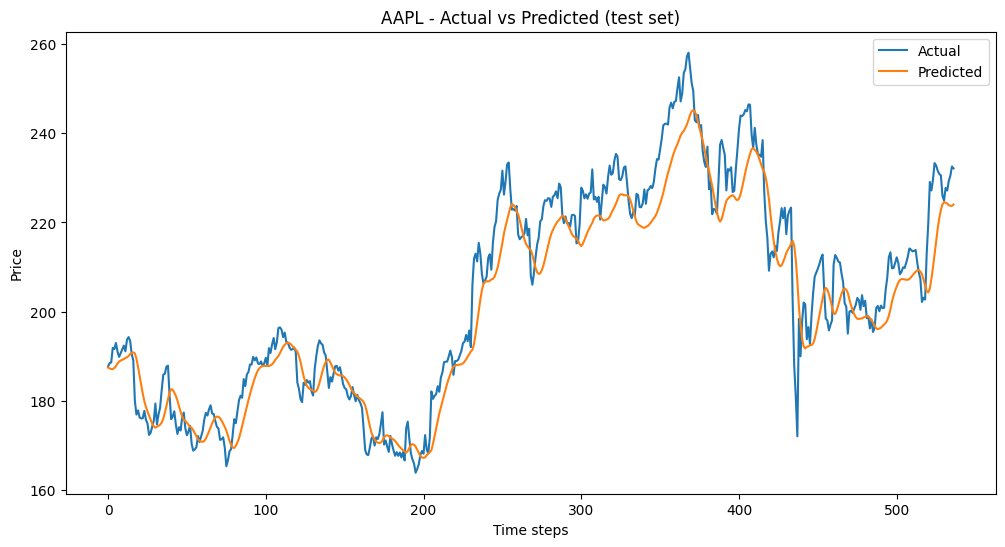

In [6]:
# ===== Cell 6: evaluate & plot predictions on test split =====
preds = model.predict(x_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot last part of dataset (actual vs predicted)
plt.plot(y_test_rescaled, label='Actual')
plt.plot(preds, label='Predicted')
plt.title(f'{TICKER} - Actual vs Predicted (test set)')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
# ===== Cell 7: predict the NEXT day price =====
# Take last SEQ_LEN days from the whole data
last_seq = scaled[-SEQ_LEN:]
X_next = last_seq.reshape((1, SEQ_LEN, 1))

pred_next = model.predict(X_next)
pred_next_price = scaler.inverse_transform(pred_next.reshape(-1,1))[0,0]

print(f"Predicted next close price for {TICKER}: {pred_next_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted next close price for AAPL: 224.38


In [8]:
# ===== Cell 8: save model & scaler =====
model.save(f'{TICKER}_lstm_model.h5')
joblib.dump(scaler, f'{TICKER}_scaler.save')
print("Saved:", f'{TICKER}_lstm_model.h5', f'{TICKER}_scaler.save')


Saved: AAPL_lstm_model.h5 AAPL_scaler.save
